In [1]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import ast
import matplotlib.pyplot as plt 
import plotly
import plotly.offline as py
from wordcloud import WordCloud, STOPWORDS
from sklearn.linear_model import LinearRegression
sb.set() 


In [2]:
df = pd.read_csv('tmdb_movies_from_2000.csv')
df.head().transpose()

0  \
adult                                                              False   
backdrop_path                           /inJjDhCjfhh3RtrJWBmmDqeuSYC.jpg   
belongs_to_collection  {'id': 535313, 'name': 'Godzilla Collection', ...   
budget                                                         200000000   
genres                 [{'id': 28, 'name': 'Action'}, {'id': 878, 'na...   
homepage                                 https://www.godzillavskong.net/   
id                                                                399566   
imdb_id                                                        tt5034838   
original_language                                                     en   
original_title                                         Godzilla vs. Kong   
overview               In a time when monsters walk the Earth, humani...   
popularity                                                       4176.63   
poster_path                             /pgqgaUx1cJb5oZQQ5v0tNARCeBp.jpg   
production_companies   [{'id': 174, 'logo_path': '/ky0xOc5OrhzkZ1N6Ky...   
production_countries   [{'iso_3166_1': 'US', 'name': 'United States o...   
release_date                                                  2021-03-24   
revenue                                                        390215000   
runtime                                                              113   
spoken_languages       [{'english_name': 'English', 'iso_639_1': 'en'...   
status                                                          Released   
tagline                                                    One Will Fall   
title                                                  Godzilla vs. Kong   
video                                                              False   
vote_average                                                         8.3   
vote_count                                                          4838   

                                                                       1  \
adult                                                              False   
backdrop_path                           /z7HLq35df6ZpRxdMAE0qE3Ge4SJ.jpg   
belongs_to_collection                                                NaN   
budget                                                                 0   
genres                 [{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...   
homepage                            https://www.netflix.com/ThunderForce   
id                                                                615678   
imdb_id                                                       tt10121392   
original_language                                                     en   
original_title                                             Thunder Force   
overview               In a world where supervillains are commonplace...   
popularity                                                       2351.08   
poster_path                             /279yOM4OQREL36B3SECnRxoB4MZ.jpg   
production_companies   [{'id': 2527, 'logo_path': '/osO7TGmlRMistSQ5J...   
production_countries   [{'iso_3166_1': 'US', 'name': 'United States o...   
release_date                                                  2021-04-09   
revenue                                                                0   
runtime                                                              107   
spoken_languages       [{'english_name': 'English', 'iso_639_1': 'en'...   
status                                                          Released   
tagline                                      Newly super. Almost heroes.   
title                                                      Thunder Force   
video                                                              False   
vote_average                                                         5.8   
vote_count                                                           402   

                                                                       2  \
adult                                    

In [3]:
df.shape

(7820, 25)

In [4]:
df[df['budget'] == 0].shape

(3663, 25)

In [5]:
df[df['revenue'] == 0].shape

(3663, 25)

In [6]:
df['return'] = df['revenue'] / df['budget']

## Data Cleaning

Remove those irrelevant data which will affect the accuracy of the prediction
### fd = filtered data

In [7]:
fd = df
fd = fd[fd['genres'] !='[]']
fd = fd[fd['belongs_to_collection'] !='[]']
fd = fd[fd['revenue'] != 0 ]
fd = fd[fd['budget'] != 0]
del fd['id']
del fd['video']

fd.shape

(3524, 24)

## Production Countries
Remove data where "production_countries" is empty

In [8]:
country_data = fd[fd['production_countries'] !='[]']

In [9]:
country_data['production_countries'] = country_data['production_countries'].fillna('[]').apply(ast.literal_eval)
country_data['production_countries'] = country_data['production_countries'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [10]:
s = country_data.apply(lambda x: pd.Series(x['production_countries']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'countries'

In [11]:
con_df = df.drop('production_countries', axis=1).join(s)
con_df = pd.DataFrame(con_df['countries'].value_counts())
con_df['country'] = con_df.index
con_df.columns = ['num_movies', 'country']
con_df = con_df.reset_index().drop('index', axis=1)
con_df.head(20)

num_movies                   country
0         3156  United States of America
1          515            United Kingdom
2          229                   Germany
3          218                    France
4          212                    Canada
5           92                     China
6           83                 Australia
7           81                     Japan
8           73                     Spain
9           48                     Italy
10          43                 Hong Kong
11          30                     India
12          29               South Korea
13          27                   Belgium
14          27            Czech Republic
15          24                   Ireland
16          24               New Zealand
17          23                    Mexico
18          18                    Russia
19          16              South Africa

### Remove production country of USA 

More than 90% of movies are production in USA. In order to make other counties more clear in map, we need to remove USA from the list

In [12]:
con_df[con_df['country'] == 'United States of America']['num_movies'] / len(fd)

0    0.895573
Name: num_movies, dtype: float64

In [13]:
con_df = con_df[con_df['country'] != 'United States of America']

In [14]:
map_data = [ dict(
        type = 'choropleth',
        locations = con_df['country'],
        locationmode = 'country names',
        z = con_df['num_movies'],
        text = con_df['country'],
        colorscale = [[0,'rgb(255, 255, 255)'],[1,'rgb(255, 0, 0)']],
        autocolorscale = False,
        reversescale = False,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            autotick = False,
            tickprefix = '',
            title = 'Production Countries'),
      ) ]

layout = dict(
    title = 'Production Countries for the Movies (Exclude US)',
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection = dict(
            type = 'Mercator'
        )
    )
)

fig = dict( data=map_data, layout=layout )
py.iplot( fig, validate=False, filename='d3-world-map' )

## Overview

Discover what keywords are more popular in the overview among these movies

In [15]:
#wordcloud_data = data[data['genres'] !='[]']
#wordcloud_data = data[data['keywords'] !='[]']
wordcloud_data = fd[fd['overview'] !=' ']

In [16]:
wordcloud_data['genres'] = wordcloud_data['genres'].fillna('[]').apply(ast.literal_eval)
wordcloud_data['genres'] = wordcloud_data['genres'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
#wordcloud_data['keywords'] = wordcloud_data['keywords'].fillna('[]').apply(ast.literal_eval)
#wordcloud_data['keywords'] = wordcloud_data['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [17]:
#wordcloud_data['genres'] = wordcloud_data['title'].astype('str')
#wordcloud_data['keywords'] = wordcloud_data['keywords'].astype('str')
wordcloud_data['overview'] = wordcloud_data['overview'].astype('str')

In [18]:
#genres_corpus = ' '.join(wordcloud_data['genres'])
#keywords_corpus = ' '.join(wordcloud_data['keywords'])
overview_corpus = ' '.join(wordcloud_data['overview'])

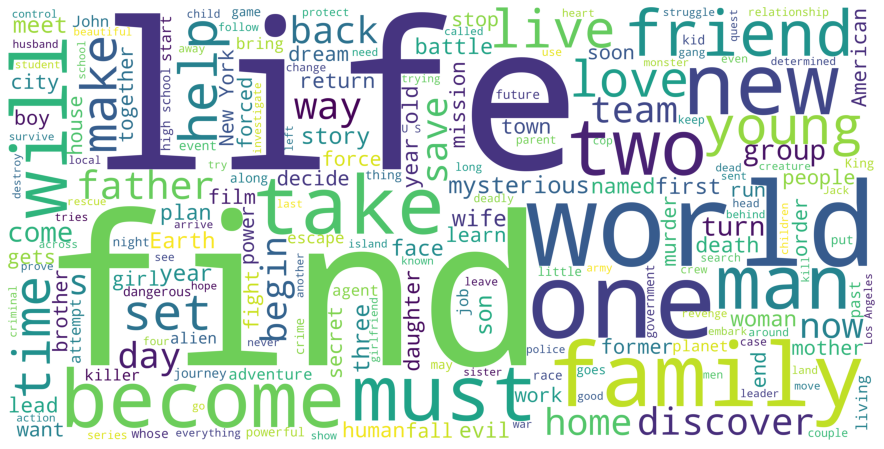

In [19]:
overview_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(overview_corpus)
plt.figure(figsize=(16,8))
plt.imshow(overview_wordcloud)
plt.axis('off')
plt.show()

## Genres

In [20]:
genres_data = fd[fd['genres'] !='[]']
genres_data

adult                     backdrop_path  \
0     False  /inJjDhCjfhh3RtrJWBmmDqeuSYC.jpg   
4     False  /5Zv5KmgZzdIvXz2KC3n0MyecSNL.jpg   
6     False  /6zbKgwgaaCyyBXE4Sun4oWQfQmi.jpg   
11    False  /z8TvnEVRenMSTemxYZwLGqFofgF.jpg   
12    False  /fev8UFNFFYsD5q7AcYS8LyTzqwl.jpg   
...     ...                               ...   
7789  False  /8v5X238laJCSGN5Oq6BHEQEOWL5.jpg   
7797  False  /oiFSwiYg1oq6sVDHFoc3pS0C0Km.jpg   
7802  False  /eqZ5t82asfprFcNS56eVruNT5G5.jpg   
7806  False  /7gvcyAbYbInPHwr3Lko7UCBCtqz.jpg   
7812  False  /qFPWfM8VTbwowGE7zWWwnRQsU4P.jpg   

                                  belongs_to_collection     budget  \
0     {'id': 535313, 'name': 'Godzilla Collection', ...  200000000   
4                                                   NaN   23000000   
6                                                   NaN   17000000   
11                                                  NaN   60000000   
12                                                  NaN   50000000   
...                                                 ...        ...   
7789  {'id': 89264, 'name': 'Romancing the Stone Col...   10000000   
7797                                                NaN   11500000   
7802  {'id': 124916, 'name': '101 Dalmatians (Live-A...   85000000   
7806                                                NaN   34000000   
7812  {'id': 2467, 'name': 'Tomb Raider Collection',...   95000000   

                                                 genres  \
0     [{'id': 28, 'name': 'Action'}, {'id': 878, 'na...   
4     [{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...   
6     [{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...   
11    [{'id': 14, 'name': 'Fantasy'}, {'id': 28, 'na...   
12    [{'id': 35, 'name': 'Comedy'}, {'id': 10751, '...   
...                                                 ...   
7789  [{'id': 12, 'name': 'Adventure'}, {'id': 28, '...   
7797  [{'id': 18, 'name': 'Drama'}, {'id': 53, 'name...   
7802  [{'id': 35, 'name': 'Comedy'}, {'id': 10751, '...   
7806  [{'id': 18, 'name': 'Drama'}, {'id': 36, 'name...   
7812  [{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...   

                              homepage    imdb_id original_language  \
0      https://www.godzillavskong.net/  tt5034838                en   
4     https://www.themarksmanmovie.com  tt6902332                en   
6             https://www.nobody.movie  tt7888964                en   
11     https://www.monsterhunter.movie  tt6475714                en   
12    https://www.tomandjerrymovie.com  tt1361336                en   
...                                ...        ...               ...   
7789                               NaN  tt0088011                en   
7797                               NaN  tt1073241                en   
7802                               NaN  tt0211181                en   
7806                               NaN  tt0104797                en   
7812                               NaN  tt0325703                en   

                                    original_title  \
0                                Godzilla vs. Kong   
4                                     The Marksman   
6                                           Nobody   
11                                  Monster Hunter   
12                                     Tom & Jerry   
...                                            ...   
7789                           Romancing the Stone   
7797                         Nothing But the Truth   
7802                                102 Dalmatians   
7806                                     Malcolm X   
7812  Lara Croft: Tomb Raider - The Cradle of Life   

                                               overview  ...  release_date  \
0     In a time when monsters walk the Earth, humani...  ...    2021-03-24   
4     Jim Hanson’s quiet life is suddenly disturbed ...  ...    2021-01-15   
6     Hutch Mansell, a suburban dad, overlooked husb...  ...    2021-03-18   
11    A portal transports Cpt. Artemis and an elite .

In [21]:
genres_data['genres'] = genres_data['genres'].fillna('[]').apply(ast.literal_eval)
genres_data['genres'] = genres_data['genres'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [22]:
genres_s = genres_data.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
genres_s.name = 'genre'
gen_df = df.drop('genres', axis=1).join(genres_s)

In [23]:
pop_gen = pd.DataFrame(gen_df['genre'].value_counts()).reset_index()
pop_gen.columns = ['genre', 'movies']
pop_gen.head(20)

genre  movies
0             Drama    1369
1            Action    1137
2            Comedy    1124
3          Thriller    1071
4         Adventure     844
5             Crime     546
6   Science Fiction     526
7            Family     515
8           Romance     506
9            Horror     506
10          Fantasy     499
11          Mystery     321
12        Animation     313
13          History     169
14            Music     128
15              War     122
16          Western      49
17      Documentary      23
18         TV Movie       2

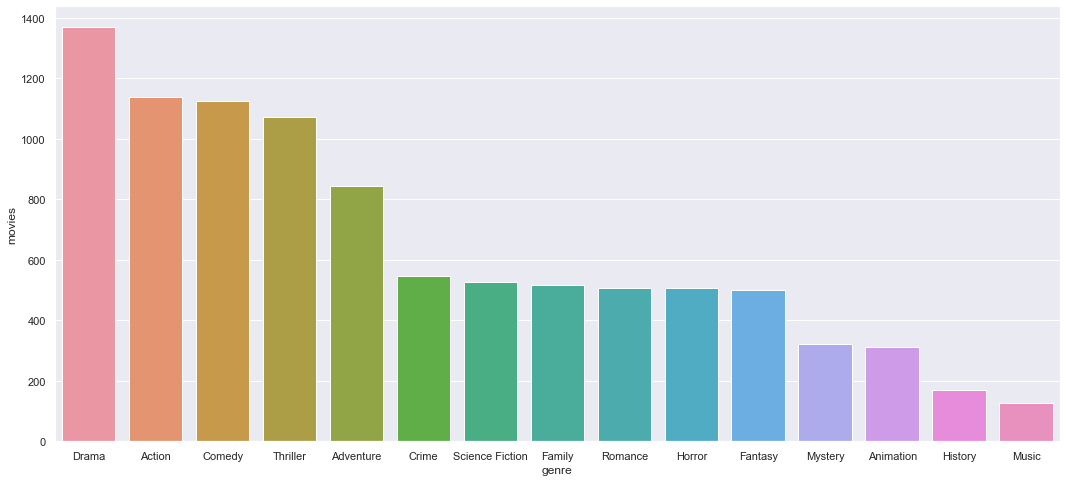

In [24]:
plt.figure(figsize=(18,8))
sb.barplot(x='genre', y='movies', data=pop_gen.head(15))
plt.show()

## Revenue Study
Remove lower 10 percentile of budget and revenue

In [25]:
revenue_data = fd[fd['revenue'] > fd['revenue'].quantile(0.1)]

revenue_data

adult                     backdrop_path  \
0     False  /inJjDhCjfhh3RtrJWBmmDqeuSYC.jpg   
4     False  /5Zv5KmgZzdIvXz2KC3n0MyecSNL.jpg   
6     False  /6zbKgwgaaCyyBXE4Sun4oWQfQmi.jpg   
11    False  /z8TvnEVRenMSTemxYZwLGqFofgF.jpg   
12    False  /fev8UFNFFYsD5q7AcYS8LyTzqwl.jpg   
...     ...                               ...   
7784  False  /1eJLkZWuFVKr6OnNkMyqgoqkU1E.jpg   
7789  False  /8v5X238laJCSGN5Oq6BHEQEOWL5.jpg   
7802  False  /eqZ5t82asfprFcNS56eVruNT5G5.jpg   
7806  False  /7gvcyAbYbInPHwr3Lko7UCBCtqz.jpg   
7812  False  /qFPWfM8VTbwowGE7zWWwnRQsU4P.jpg   

                                  belongs_to_collection     budget  \
0     {'id': 535313, 'name': 'Godzilla Collection', ...  200000000   
4                                                   NaN   23000000   
6                                                   NaN   17000000   
11                                                  NaN   60000000   
12                                                  NaN   50000000   
...                                                 ...        ...   
7784  {'id': 624521, 'name': 'Shaun the Sheep Collec...   25000000   
7789  {'id': 89264, 'name': 'Romancing the Stone Col...   10000000   
7802  {'id': 124916, 'name': '101 Dalmatians (Live-A...   85000000   
7806                                                NaN   34000000   
7812  {'id': 2467, 'name': 'Tomb Raider Collection',...   95000000   

                                                 genres  \
0     [{'id': 28, 'name': 'Action'}, {'id': 878, 'na...   
4     [{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...   
6     [{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...   
11    [{'id': 14, 'name': 'Fantasy'}, {'id': 28, 'na...   
12    [{'id': 35, 'name': 'Comedy'}, {'id': 10751, '...   
...                                                 ...   
7784  [{'id': 10751, 'name': 'Family'}, {'id': 16, '...   
7789  [{'id': 12, 'name': 'Adventure'}, {'id': 28, '...   
7802  [{'id': 35, 'name': 'Comedy'}, {'id': 10751, '...   
7806  [{'id': 18, 'name': 'Drama'}, {'id': 36, 'name...   
7812  [{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...   

                              homepage    imdb_id original_language  \
0      https://www.godzillavskong.net/  tt5034838                en   
4     https://www.themarksmanmovie.com  tt6902332                en   
6             https://www.nobody.movie  tt7888964                en   
11     https://www.monsterhunter.movie  tt6475714                en   
12    https://www.tomandjerrymovie.com  tt1361336                en   
...                                ...        ...               ...   
7784     http://www.shaunthesheep.com/  tt2872750                en   
7789                               NaN  tt0088011                en   
7802                               NaN  tt0211181                en   
7806                               NaN  tt0104797                en   
7812                               NaN  tt0325703                en   

                                    original_title  \
0                                Godzilla vs. Kong   
4                                     The Marksman   
6                                           Nobody   
11                                  Monster Hunter   
12                                     Tom & Jerry   
...                                            ...   
7784                         Shaun the Sheep Movie   
7789                           Romancing the Stone   
7802                                102 Dalmatians   
7806                                     Malcolm X   
7812  Lara Croft: Tomb Raider - The Cradle of Life   

                                               overview  ...  release_date  \
0     In a time when monsters walk the Earth, humani...  ...    2021-03-24   
4     Jim Hanson’s quiet life is suddenly disturbed ...  ...    2021-01-15   
6     Hutch Mansell, a suburban dad, overlooked husb...  ...    2021-03-18   
11    A portal transports Cpt. Artemis and an elite .

In [26]:
revenue_data['revenue'].describe()

count    3.171000e+03
mean     1.599780e+08
std      2.230505e+08
min      5.750000e+06
25%      3.516694e+07
50%      8.332000e+07
75%      1.880087e+08
max      2.797801e+09
Name: revenue, dtype: float64

In [27]:
revenue_data['revenue'].describe()

count    3.171000e+03
mean     1.599780e+08
std      2.230505e+08
min      5.750000e+06
25%      3.516694e+07
50%      8.332000e+07
75%      1.880087e+08
max      2.797801e+09
Name: revenue, dtype: float64

## Predicting Revenue using Budget
Plot Revenue against Budget using standard ScatterPlot/JointPlot.

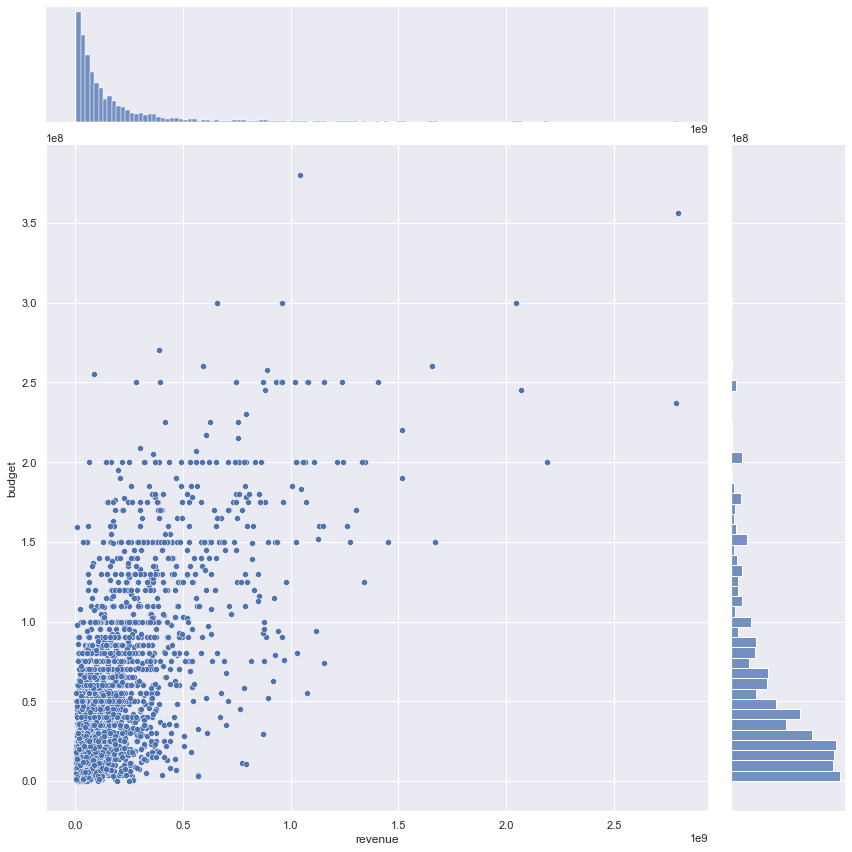

In [28]:
sb.jointplot(data = revenue_data, x = "revenue", y = "budget", height = 12)

In [29]:
print("Correlation Coefficient: ", revenue_data.revenue.corr(revenue_data.budget))

Correlation Coefficient:  0.6977011029628251


In [30]:
# Import LinearRegression model from Scikit-Learn
from sklearn.linear_model import LinearRegression

# Create a Linear Regression object
linreg = LinearRegression()
# Import the required function from sklearn
from sklearn.model_selection import train_test_split

# Extract Response and Predictors
y = pd.DataFrame(revenue_data['revenue'])
X = pd.DataFrame(revenue_data['budget'])

# Split the Dataset into random Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

# Check the sample sizes
print("Train Set :", X_train.shape, y_train.shape)
print("Test Set  :", X_test.shape, y_test.shape)

Train Set : (2378, 1) (2378, 1)
Test Set  : (793, 1) (793, 1)


Fit Linear Regression model on the Training Dataset.

In [31]:
linreg.fit(X_train, y_train)

LinearRegression()

#### Visual Representation of the Linear Regression Model

Check the coefficients of the Linear Regression model you just fit.

In [32]:
print('Intercept \t: b = ', linreg.intercept_)
print('Coefficients \t: a = ', linreg.coef_)

Intercept 	: b =  [9145610.90404794]
Coefficients 	: a =  [[3.13018436]]


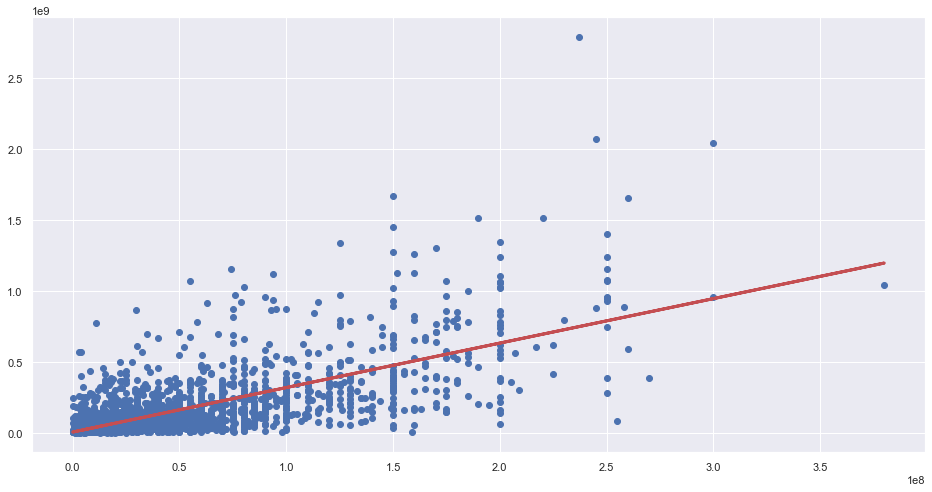

In [33]:
# Formula for the Regression line
regline_x = X_train
regline_y = linreg.intercept_ + linreg.coef_ * X_train

# Plot the Linear Regression line
f, axes = plt.subplots(1, 1, figsize=(16, 8))
plt.scatter(X_train, y_train)
plt.plot(regline_x, regline_y, 'r-', linewidth = 3)
plt.show()

# Goodness of Fit of the Linear Regression Model
Check how good the predictions are on the Train Set.

Metric: Explained Variance or R^2 on the Train Set.

Metric: Mean Squared Error (MSE) on the Train Set.

In [34]:
# Explained Variance in simply the "Score"
print("Explained Variance (R^2) \t:", linreg.score(X_train, y_train))

# Import the required metric from sklearn
from sklearn.metrics import mean_squared_error

# Predict the response on the train set
y_train_pred = linreg.predict(X_train)

# Compute MSE on the train set
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))

Explained Variance (R^2) 	: 0.47660508729472817
Mean Squared Error (MSE) 	: 2.6102966659916256e+16


# Prediction of Response based on the Predictor
Predict Revenue given Budget in the Test dataset.

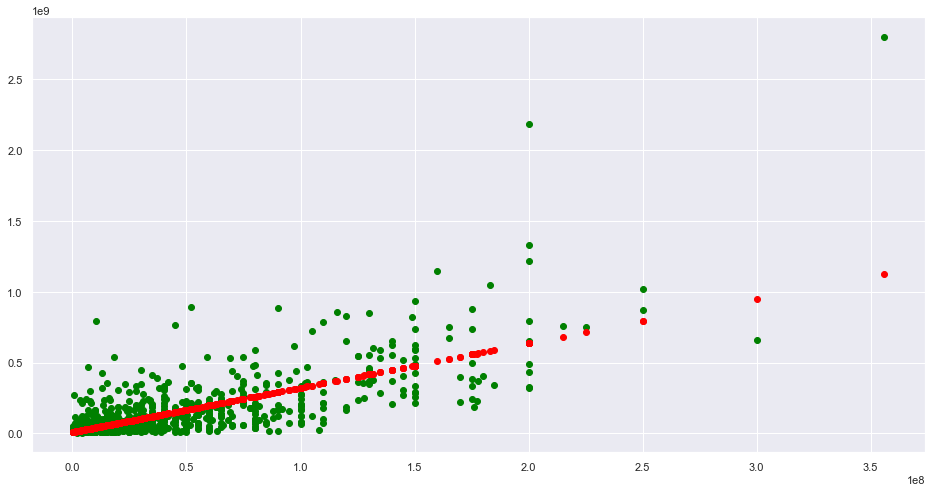

In [35]:
# Predict Revenue values corresponding to Budget
y_test_pred = linreg.predict(X_test)

# Plot the Predictions on a Scatterplot
f = plt.figure(figsize=(16, 8))
plt.scatter(X_test, y_test, color = "green")
plt.scatter(X_test, y_test_pred, color = "red")
plt.show()

### Goodness of Fit of the Linear Regression Model
Check how good the predictions are on the Test Set.

Metric: Mean Squared Error (MSE) on the Test Set.

In [36]:
# Compute MSE on the test set
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))

Mean Squared Error (MSE) 	: 2.3820313885839364e+16


## Predicting Revenue using Popularity
Plot Revenue against Popularity using standard ScatterPlot/JointPlot.

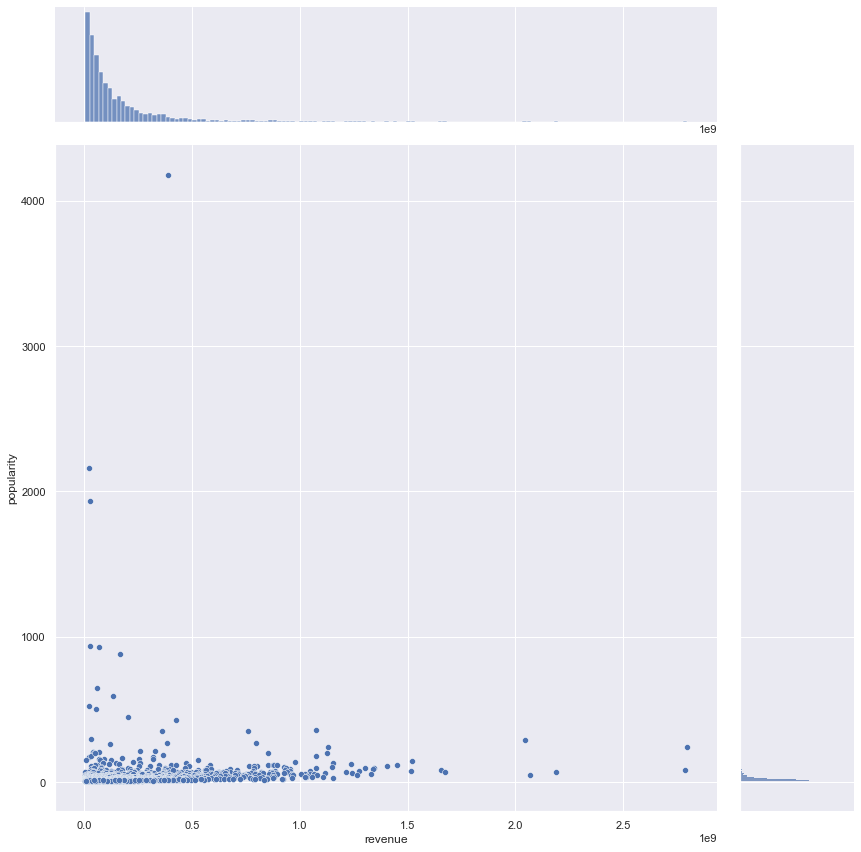

In [37]:
sb.jointplot(data = revenue_data, x = "revenue", y = "popularity", height = 12)

In [38]:
print("Correlation Coefficient: ", revenue_data.revenue.corr(revenue_data.popularity))

Correlation Coefficient:  0.13091950107167497


In [39]:
# Import LinearRegression model from Scikit-Learn
from sklearn.linear_model import LinearRegression

# Create a Linear Regression object
linreg = LinearRegression()
# Import the required function from sklearn
from sklearn.model_selection import train_test_split

# Extract Response and Predictors
y = pd.DataFrame(revenue_data['revenue'])
X = pd.DataFrame(revenue_data['popularity'])

# Split the Dataset into random Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

# Check the sample sizes
print("Train Set :", X_train.shape, y_train.shape)
print("Test Set  :", X_test.shape, y_test.shape)

Train Set : (2378, 1) (2378, 1)
Test Set  : (793, 1) (793, 1)


Fit Linear Regression model on the Training Dataset.

In [40]:
linreg.fit(X_train, y_train)

LinearRegression()

In [41]:
print('Intercept \t: b = ', linreg.intercept_)
print('Coefficients \t: a = ', linreg.coef_)

Intercept 	: b =  [1.54052551e+08]
Coefficients 	: a =  [[289103.63860792]]


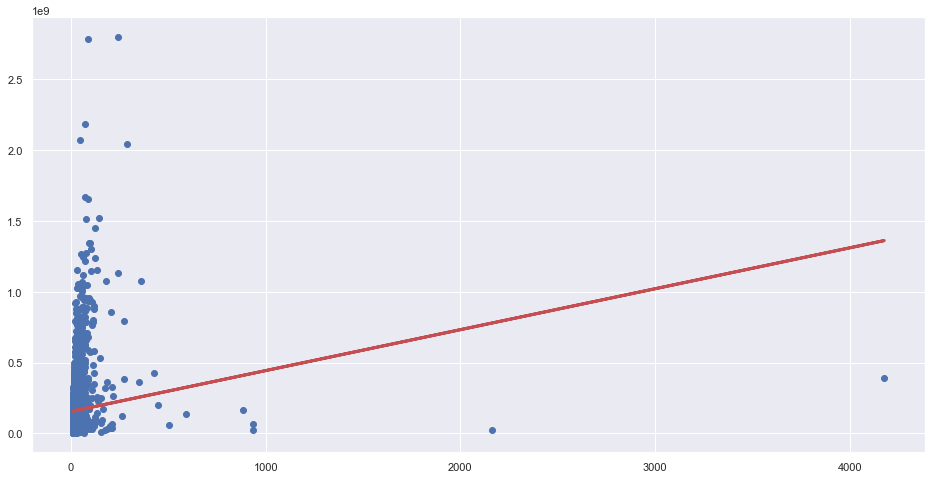

In [42]:
# Formula for the Regression line
regline_x = X_train
regline_y = linreg.intercept_ + linreg.coef_ * X_train

# Plot the Linear Regression line
f, axes = plt.subplots(1, 1, figsize=(16, 8))
plt.scatter(X_train, y_train)
plt.plot(regline_x, regline_y, 'r-', linewidth = 3)
plt.show()

# Goodness of Fit of the Linear Regression Model
Check how good the predictions are on the Train Set.

Metric: Explained Variance or R^2 on the Train Set.

Metric: Mean Squared Error (MSE) on the Train Set.

In [43]:
# Explained Variance in simply the "Score"
print("Explained Variance (R^2) \t:", linreg.score(X_train, y_train))

# Import the required metric from sklearn
from sklearn.metrics import mean_squared_error

# Predict the response on the train set
y_train_pred = linreg.predict(X_train)

# Compute MSE on the train set
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))

Explained Variance (R^2) 	: 0.017599793583959022
Mean Squared Error (MSE) 	: 5.257528324127146e+16


# Prediction of Response based on the Predictor
Predict Revenue given Popularity in the Test dataset.

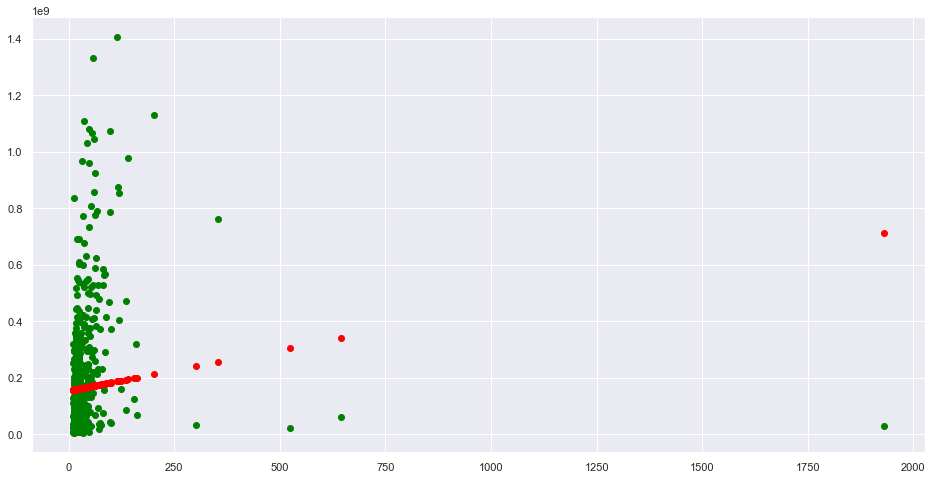

In [44]:
# Predict Revenue values corresponding to Popularity
y_test_pred = linreg.predict(X_test)

# Plot the Predictions on a Scatterplot
f = plt.figure(figsize=(16, 8))
plt.scatter(X_test, y_test, color = "green")
plt.scatter(X_test, y_test_pred, color = "red")
plt.show()

### Goodness of Fit of the Linear Regression Model
Check how good the predictions are on the Test Set.

Metric: Mean Squared Error (MSE) on the Test Set.

In [45]:
# Compute MSE on the test set
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))

Mean Squared Error (MSE) 	: 3.785438645541356e+16


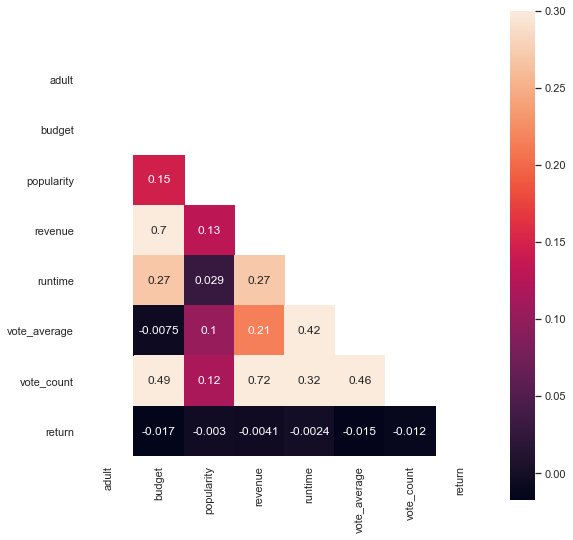

In [46]:
sb.set(font_scale=1)
corr = revenue_data.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sb.axes_style("white"):
    plt.figure(figsize=(9,9))
    ax = sb.heatmap(corr, mask=mask, vmax=.3, square=True, annot=True)

### From above Linear Regression Model, we realized that most suitable predictors for revenue (in terms of  Correlation Coefficient)  are vote_count(0.72) > budget(0.7) > popularity(0.13). However, vote_count will not be availbale before the movie releasing, so we need to study the relationship between Budget and Genres.

## Relationshio between Budget and Genres

Following genres cover most of the movie, we would like to find out which genres will generate highest revenue.

In [47]:
pop_genres = ['Drama', 'Comedy', 'Thriller', 'Romance', 'Action', 'Horror', 'Crime', 'Science Fiction', 'Fantasy', 'Animation']
pop_movies = gen_df[(gen_df['genre'].isin(pop_genres))]

<Figure size 1296x864 with 0 Axes>

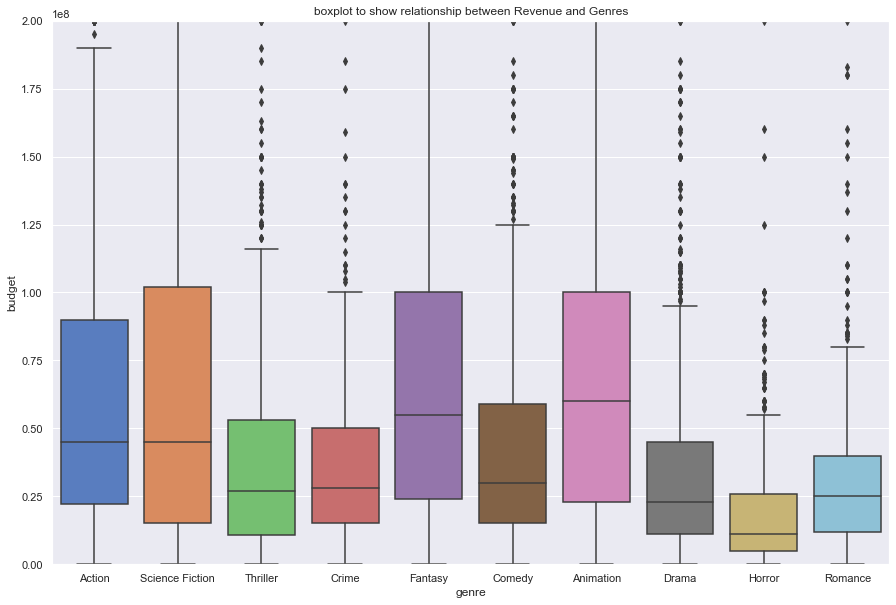

In [48]:
plt.figure(figsize=(18,12))
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(15, 10))
sb.boxplot(x='genre', y='budget', data=pop_movies, palette="muted", ax =ax)
ax.set_ylim([0, 2e8])
plt.title("boxplot to show relationship between Revenue and Genres")
plt.show()

## Relationshio between Revenue and Genres

Following genres cover most of the movie, we would like to find out which genres will generate highest revenue.

<Figure size 1296x864 with 0 Axes>

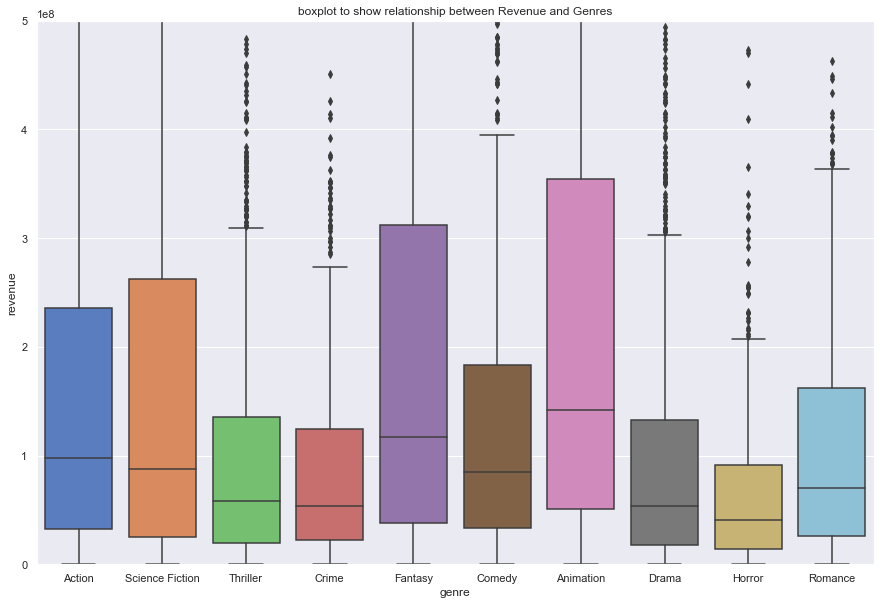

In [49]:
plt.figure(figsize=(18,12))
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(15, 10))
sb.boxplot(x='genre', y='revenue', data=pop_movies, palette="muted", ax =ax)
ax.set_ylim([0, 5e8])
plt.title("boxplot to show relationship between Revenue and Genres")
plt.show()

From above box plot, Animation produce the highest Median among other genres. Also, it prodeces the largeest Interquartile Range(IQR)

## Relationship between Return and Genres

Following genres cover most of the movie, we would like to find out which genres will be most profitable in terms of Return.

<Figure size 1296x864 with 0 Axes>

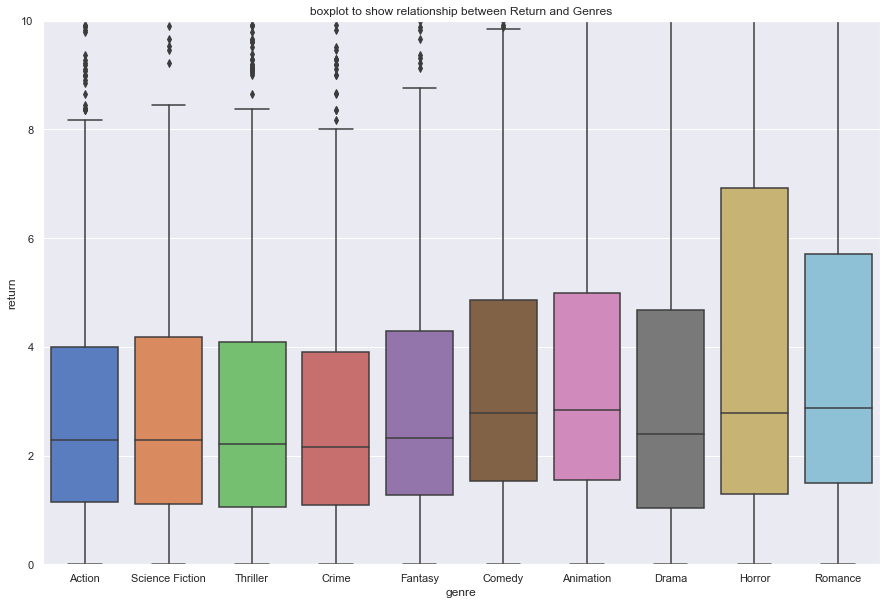

In [50]:
plt.figure(figsize=(18,12))
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(15, 10))
sb.boxplot(x='genre', y='return', data=pop_movies, palette="muted", ax =ax)
ax.set_ylim([0, 10])
plt.title("boxplot to show relationship between Return and Genres")
plt.show()

In terms of Return, most genres produce return between 2~4, Animation and Horror generate highest Median, and Horror prodeces the largeest Interquartile Range(IQR). 

Compare the boxplots (Revenue against Genres) and（Return again Genres) we found out the revenue for Horror movie is the lowest in terms of Median but the return is one of the highest. It indicates Horror movies produce very high Rutern On Investment(ROI) compare to other genres. 

### Conclusion: Horror movie is a good choise for low budget investment.